In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torchvision

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [12]:
nPerClass = 1000
imgSize = 30

# x = np.linspace(-4, 4, imgSize)
# X, Y = np.meshgrid(x, x)

widths = [1.8, 2.4]

images = torch.zeros(2*nPerClass, 1, imgSize, imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):
    # ro = 2*np.random.randn(2) # random offset
    # G = np.exp( -( (X - ro[0])**2 + (Y - ro[1])**2 ) / (2*widths[i%2]**2) ) # formula for Gaussian

    G = np.random.randn(imgSize, imgSize)/3 # adding noise

    # adding a bar randomly
    i1 = np.random.choice(np.arange(2, 28))
    i2 = np.random.choice(np.arange(2, 6))

    if np.random.randn() > 0:
        G[i1:i1+2, ] = 1
        labels[i] = 0 # horizontal
    else:
        G[:, i1:i1+i2] = 1
        labels[i] = 1 # vertical

    images[i,:,:,:] = torch.Tensor(G).view(1, imgSize, imgSize)

labels = labels[:, None]

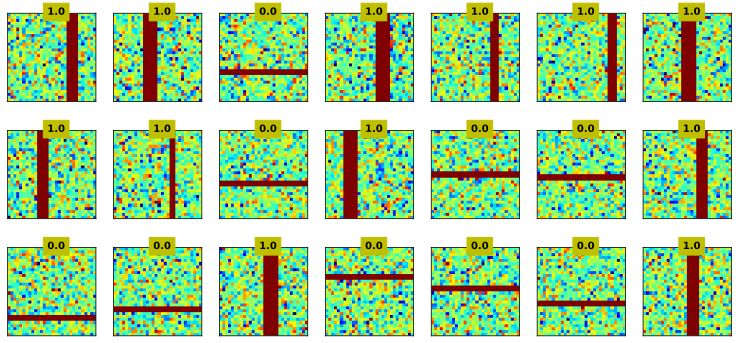

In [16]:
fig, axs = plt.subplots(3, 7, figsize = (13, 6))

for i, ax in enumerate(axs.flatten()):
    whichPic = np.random.randint(nPerClass)
    G = np.squeeze(images[whichPic, :, :])
    label = labels[whichPic,:].item()
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [21]:
labels.shape

torch.Size([2000, 1])

In [22]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, train_size=0.9)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [30]:
test_loader.dataset.tensors[1].shape

torch.Size([200, 1])

In [34]:
class Model(nn.Module):
    def __init__ (self, printtoggle=False):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        # size of output image = np.floor( (30+2*1-3)/1 )+1 = 30/2 = 15 (/2 b/c maxpool)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # size of output image = np.floor( (15+2*1-3)/1 )+1 = 15/2 = 7 (/2 b/c maxpool)

        # computing number of units in fully connected layer (output of conv2)
        # it should be number of channels X height of image X width of image
        expectSize = 128*7*7

        self.fc1 = nn.Linear(expectSize, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

        # toggle for printing out tensor sizes during forward prop
        self.print = printtoggle

    def forward(self, x):
        print(f'Input: {x.shape}') if self.print else None

        # convolution -> max pooling -> relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 2 is size of the pooling region or spatial extent or window size
        print(f'Layer conv1/pool1: {x.shape}') if self.print else None

        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        print(f'Layer conv2/pool2: {x.shape}') if self.print else None

        # reshape for FC layer
        nUnits = x.shape.numel()/x.shape[0]
        # here x.shape = (batch_size, channels, height, width)
        # and x.shape.numel() gives the product of batch_size, channels, height, width, hence it returns the total number of elements in tensor x
        # x.shape[0] = batch_size
        # so, nUnits is number of elements per batch or sample. This will be equal to expectSize
        if self.print: print(f'nUnits: {nUnits}')

        x = x.view(-1, int(nUnits))
        # here we are flattening the elements. view is used to reshape the tensor.
        # -1 is used when we don't know how many rows are required to fit the number elements specified in the column parameter.
        # if -1 is used at column parameter, like x.view(int(nUnits), -1), then it calculates the required number of rows.
        if self.print: print(f'Vectorize: {x.shape}')

        x = F.relu(self.fc1(x))
        if self.print: print(f'Layer fc1: {x.shape}')
        x = F.relu(self.fc2(x))
        if self.print: print(f'Layer fc2: {x.shape}')
        x = self.out(x)
        if self.print: print(f'Layer out: {x.shape}')

        return x

In [35]:
def getModel(printtoggle=False):
    
    CNN = Model(printtoggle)

    lossFunction = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

    return CNN, lossFunction, optimizer

In [36]:
# testing model

CNN, lossFunction, optimizer = getModel(True)

X, y = next(iter(train_loader))
yHat = CNN(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossFunction(yHat, y)
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 1, 30, 30])
Layer conv1/pool1: torch.Size([32, 64, 15, 15])
Layer conv2/pool2: torch.Size([32, 128, 7, 7])
nUnits: 6272.0
Vectorize: torch.Size([32, 6272])
Layer fc1: torch.Size([32, 128])
Layer fc2: torch.Size([32, 64])
Layer out: torch.Size([32, 1])
 
torch.Size([32, 1])
torch.Size([32, 1])
 
Loss:
tensor(0.6892, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [85]:
def trainModel(CNN, lossFunction, optimizer):
    epochs = 10

    trainLoss = torch.zeros(epochs)
    testLoss = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):

        CNN.train()
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = CNN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # convert output to probability via sigmoid
            yy = torch.sigmoid(yHat)

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean(((yy > 0.5)==y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        trainLoss[_] = np.mean(batchLoss)

        CNN.eval()
        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = CNN(X)
            loss = lossFunction(pred, Y)
        
        # convert output to probability via sigmoid
        yy = torch.sigmoid(pred)

        testAcc.append(torch.mean(((yy > 0.5)==Y).float())*100)
        testLoss[_] = loss.item()

        print(' ')
        print('Completed epoch ', _)

    return trainAcc, testAcc, trainLoss, testLoss, CNN

In [86]:
CNN, lossFunction, optimizer = getModel(False)
trainAcc, testAcc, trainLoss, testLoss, CNN = trainModel(CNN, lossFunction, optimizer)

 
Completed epoch  0
 
Completed epoch  1
 
Completed epoch  2
 
Completed epoch  3
 
Completed epoch  4
 
Completed epoch  5
 
Completed epoch  6
 
Completed epoch  7
 
Completed epoch  8
 
Completed epoch  9


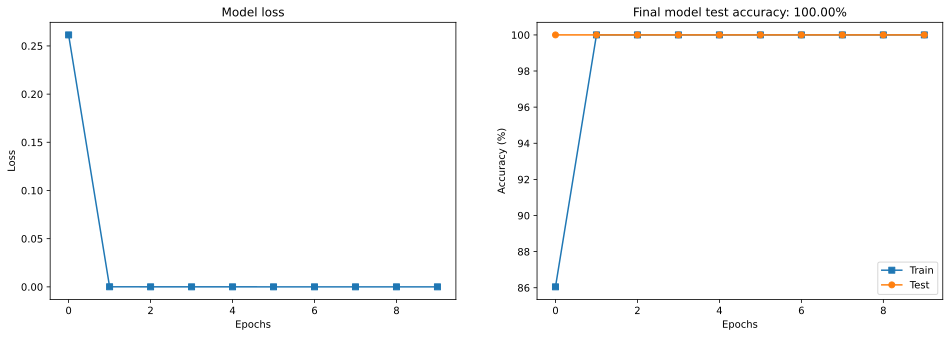

In [87]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [40]:
from skimage.draw import line_aa

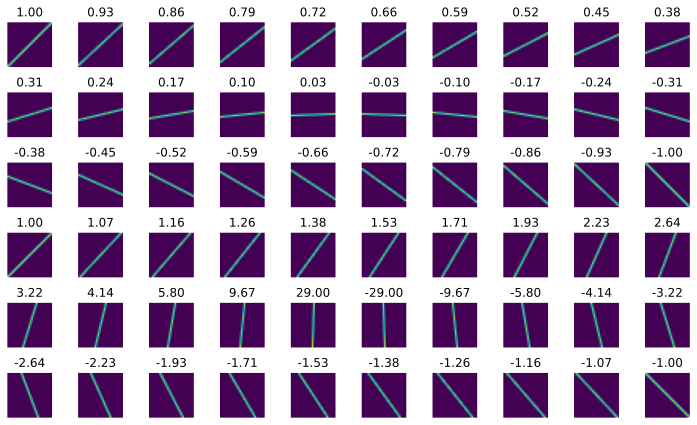

In [88]:
fig,ax = plt.subplots(6,10,figsize=(10,6))
imgs   = np.zeros((2*imgSize,1,imgSize,imgSize))
slopes = np.zeros(2*imgSize)

a = ax.flatten()
for i in range(imgSize):

  ### create lines with |slope|<1
  # point coords
  p1 = [0,i]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i,0,rows,cols] = val

  # plot
  a[i].imshow(imgs[i,0,:,:],origin='lower')
  a[i].set_title('%.2f'%slopes[i])
  a[i].axis('off')
  

  ### create lines with |slope|>1
  # point coords
  p1 = [i,0]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i+imgSize] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i+imgSize,0,rows,cols] = val

  # plot
  a[i+imgSize].imshow(imgs[i+imgSize,0,:,:],origin='lower')
  a[i+imgSize].set_title('%.2f'%slopes[i+imgSize])
  a[i+imgSize].axis('off')

plt.tight_layout()
plt.show()

In [89]:
# randomly shuffle the images, just to be on the safe side...
# and also convert to tensor...

ridx = np.random.permutation(range(imgs.shape[0]))
imgT = torch.tensor(imgs[ridx,:,:,:].astype(np.float32))

In [93]:
# now generate the prediction (horizontal or vertical)
CNN.eval()
yHat =  torch.sigmoid( CNN(imgT) ).detach()

In [95]:
print(f"Shapes -> slopes: {slopes.shape}, yHat: {yHat.shape}, ridx: {ridx.shape}")

Shapes -> slopes: (60,), yHat: torch.Size([60, 1]), ridx: (60,)


tensor([9.8677e-01, 9.9932e-01, 8.1293e-01, 3.1534e-01, 5.9598e-03, 9.7482e-04,
        9.9902e-01, 1.2300e-03, 3.3289e-03, 8.9114e-01, 9.5461e-04, 1.6850e-01,
        8.6020e-04, 5.0134e-01, 1.9878e-02, 1.0398e-03, 4.3101e-01, 1.1342e-03,
        1.0546e-03, 9.8705e-04, 9.9909e-01, 1.6827e-03, 9.9942e-01, 4.3101e-01,
        4.9134e-01, 9.9941e-01, 5.2377e-03, 8.5980e-04, 1.2374e-03, 1.1589e-03,
        8.8676e-04, 1.4572e-01, 9.9795e-01, 1.0453e-03, 9.9743e-01, 2.8564e-02,
        8.0426e-04, 1.7436e-03, 9.9938e-01, 9.9543e-01, 1.0065e-01, 9.9890e-01,
        9.5046e-01, 7.0624e-01, 6.6608e-01, 9.0725e-01, 4.6532e-02, 7.8217e-01,
        9.9265e-01, 9.4436e-01, 9.9926e-01, 1.2310e-02, 9.7464e-01, 9.9947e-01,
        1.6850e-01, 2.5189e-03, 7.5795e-04, 9.7944e-01, 9.5869e-03, 1.0891e-03])


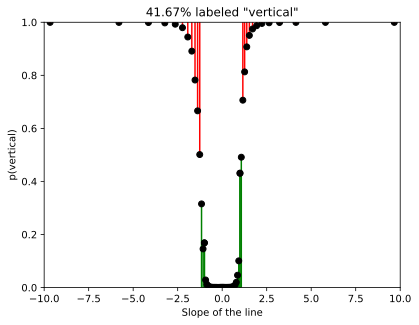

In [96]:

yHatFlat = yHat.flatten()
print(yHatFlat)
# plot the results (make sure the slopes use the same randomization)
for i in range(len(slopes)):
  if yHatFlat[i]>.5:
    plt.plot([slopes[ridx[i]],slopes[ridx[i]]],[1,yHatFlat[i]],'r')
  else:
    plt.plot([slopes[ridx[i]],slopes[ridx[i]]],[0,yHatFlat[i]],'g')

plt.plot(slopes[ridx],yHatFlat,'ko')
plt.xlabel('Slope of the line')
plt.ylabel('p(vertical)')
plt.title('%.2f%% labeled "vertical"' %torch.mean(100*(yHatFlat>.5).float()).item())
plt.ylim([0,1])
plt.xlim([-10,10]) # note: this actually clips two data points
plt.show()

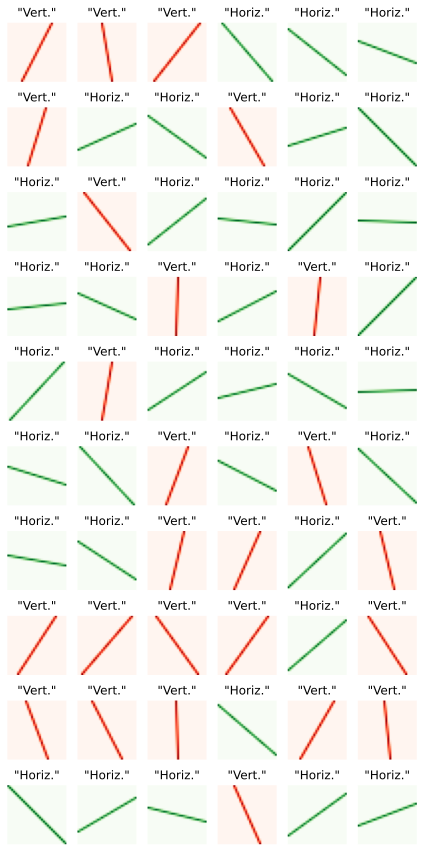

In [97]:
fig,ax = plt.subplots(10,6,figsize=(6,12))

for i,a in enumerate(ax.flatten()):
  
  # show the line-image (make sure to use the randomization index)
  if yHat[i]>.5:
    a.imshow(imgs[ridx[i],0,:,:],origin='lower',cmap='Reds')
  else:
    a.imshow(imgs[ridx[i],0,:,:],origin='lower',cmap='Greens')
  
  # and the title
  title = '"Vert."' if yHat[i].detach()>.5 else '"Horiz."'
  a.set_title(title)
  a.axis('off')

plt.tight_layout()
plt.show()